# EDA

In [220]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import regex as re

Load datasets

In [178]:
products = pd.read_csv('datasets_clean/df_products_clean.csv')
ratings = pd.read_csv('datasets_clean/df_ratings_clean.csv')
summaries = pd.read_csv('datasets_clean/df_summaries_clean.csv')
reviews = pd.read_csv('datasets_clean/df_reviews_clean.csv')

### Products

In [6]:
# Create separate dataframes for sale and regular priced products for easier comparison
sale_prod = products[products['target'] == 1]
reg_prod = products[products['target'] == 0]

In [7]:
sale_prod.describe()

,listPrice,salePrice,skuId,review_count,target
count,185.000000,185.000000,1.850000e+02,185.000000,185.0
mean,30.170270,18.009730,1.935692e+06,37.318919,1.0
std,18.926616,14.165534,1.601297e+05,118.952497,0.0
min,6.000000,3.000000,1.359850e+06,1.000000,1.0
25%,20.000000,10.000000,1.805563e+06,1.000000,1.0
50%,27.000000,15.000000,1.935576e+06,5.000000,1.0
75%,38.000000,21.750000,2.071439e+06,23.000000,1.0
max,149.000000,105.000000,2.226785e+06,984.000000,1.0


In [8]:
reg_prod.describe()

,listPrice,salePrice,skuId,review_count,target
count,3349.000000,3349.0,3.349000e+03,3349.000000,3349.0
mean,35.671335,0.0,1.919525e+06,102.031353,0.0
std,23.486541,0.0,3.466956e+05,289.900479,0.0
min,2.000000,0.0,4.857900e+04,1.000000,0.0
25%,24.000000,0.0,1.813229e+06,1.000000,0.0
50%,30.000000,0.0,2.016699e+06,7.000000,0.0
75%,42.000000,0.0,2.166403e+06,68.000000,0.0
max,270.000000,0.0,2.282051e+06,3883.000000,0.0


From the makeup products only on Sephora, there are a total of 3,534 products. Of those 3,534 products, 185 are on sale. This makes up only 5% of the total products.  
  
The average prices for sale products were less than those that were regularly priced. However, the median was more similar with median sale prices being 27 dollars and median regular sitting at 30 dollars.

In [9]:
spc = pd.DataFrame(sale_prod['category'].value_counts())

In [10]:
rpc = reg_prod['category'].value_counts()

In [11]:
c_count = pd.merge(left = spc, right = rpc, how = 'right', left_on = spc.index, right_on = rpc.index)
c_count.fillna(0, inplace = True)

In [12]:
c_count['pct_sale'] = np.round(c_count['category_x']/c_count['category_y'],2)

In [13]:
c_count.sort_values(by = 'pct_sale', ascending = False).head()

,key_0,category_x,category_y,pct_sale
16,lip-plumper,4.0,25,0.16
3,liquid-lipstick,12.0,79,0.15
7,lip-palettes-gloss-sets,8.0,52,0.15
13,fake-eyelashes-false-eyelashes,5.0,37,0.14
12,lip-liner-lip-pencils,6.0,43,0.14


In [14]:
# Sale priced makeup count by descending 
c_count.sort_values(by = 'category_x', ascending = False).head()

,key_0,category_x,category_y,pct_sale
0,lipstick,25.0,268,0.09
1,luminizer-luminous-makeup,20.0,232,0.09
2,eyeshadow,16.0,276,0.06
3,liquid-lipstick,12.0,79,0.15
4,eyeshadow-palettes,11.0,208,0.05


In [15]:
# Regular priced makeup count by descending 
c_count.sort_values(by = 'category_y', ascending = False).head()

,key_0,category_x,category_y,pct_sale
2,eyeshadow,16.0,276,0.06
0,lipstick,25.0,268,0.09
1,luminizer-luminous-makeup,20.0,232,0.09
20,foundation-makeup,3.0,213,0.01
4,eyeshadow-palettes,11.0,208,0.05


Unsurprisingly, the most products to go on sale are lipsticks, which also account for the most number of products. It is interesting to note that general lip products consisted of the highest percent of sale products. 

In [129]:
sale_prod['sale_pct'] = np.round(((sale_prod['listPrice'] - sale_prod['salePrice'])/sale_prod['listPrice']),3)*100

/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [130]:
sale_prod.groupby(by = 'category').mean().sort_values('sale_pct', ascending = False).head(5)

,isLimitedEdition,isNew,isOnlineOnly,isSephoraExclusive,listPrice,salePrice,skuId,review_count,target,sale_pct
category,,,,,,,,,,
eyeshadow-primer-eye-primer,0.500000,0.0,0.0,1.00,14.000000,5.000000,1.838969e+06,8.000000,1.0,64.250000
contour-palette-brush,0.666667,0.0,0.0,1.00,41.333333,20.333333,1.664278e+06,3.666667,1.0,51.266667
liquid-lipstick,0.333333,0.0,0.0,0.75,21.541667,10.904167,1.957420e+06,85.166667,1.0,50.316667
bronzer-makeup,0.000000,0.0,0.5,0.50,37.500000,20.000000,1.887702e+06,10.000000,1.0,50.000000
color-correcting,0.000000,0.0,0.0,1.00,29.750000,14.875000,1.881976e+06,4.500000,1.0,50.000000


In [131]:
sale_prod.groupby(by = 'category').mean().sort_values('sale_pct', ascending = True).head(5)

,isLimitedEdition,isNew,isOnlineOnly,isSephoraExclusive,listPrice,salePrice,skuId,review_count,target,sale_pct
category,,,,,,,,,,
lip-plumper,0.000,0.0,0.250000,0.750000,21.000000,15.25000,1.912338e+06,5.500000,1.0,27.100000
lip-balm-treatments-lips-makeup,0.125,0.0,0.375000,0.500000,32.000000,23.16875,1.882576e+06,5.625000,1.0,30.350000
under-eye-concealer,0.000,0.0,0.000000,0.333333,30.166667,19.75000,1.975177e+06,344.666667,1.0,34.466667
concealer,0.000,0.0,0.000000,0.400000,31.700000,20.15000,1.887799e+06,222.200000,1.0,36.840000
foundation-makeup,0.000,0.0,0.333333,0.666667,41.666667,25.50000,1.772903e+06,15.666667,1.0,38.333333


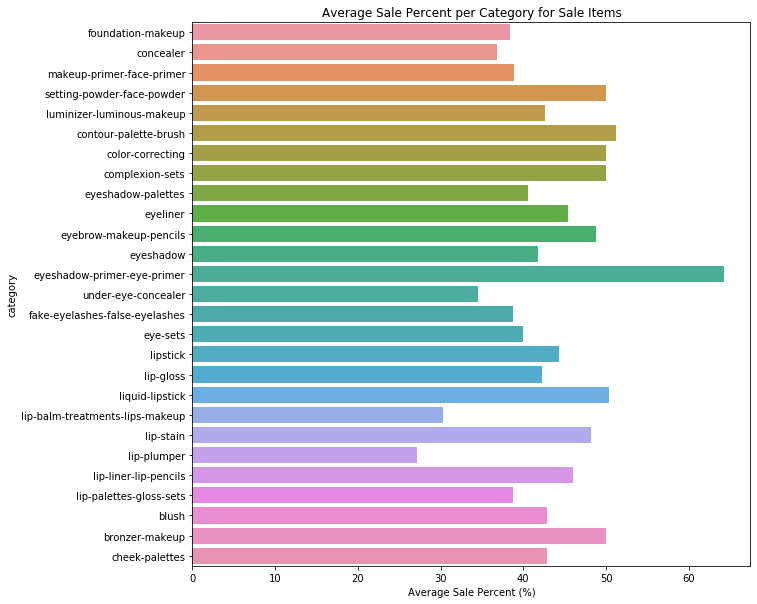

In [134]:
plt.figure(figsize = (10, 10))
sns.barplot(data = sale_prod, y = 'category', x = 'sale_pct', ci = None)
plt.title('Average Sale Percent per Category for Sale Items')
plt.xlabel('Average Sale Percent (%)');

The percent sale of these products could depend on the manufacturing costs as well as contract agreements for certain brands. A lip product is in the top percent change in price. It also happens to be 2nd highest product to go on sale. 

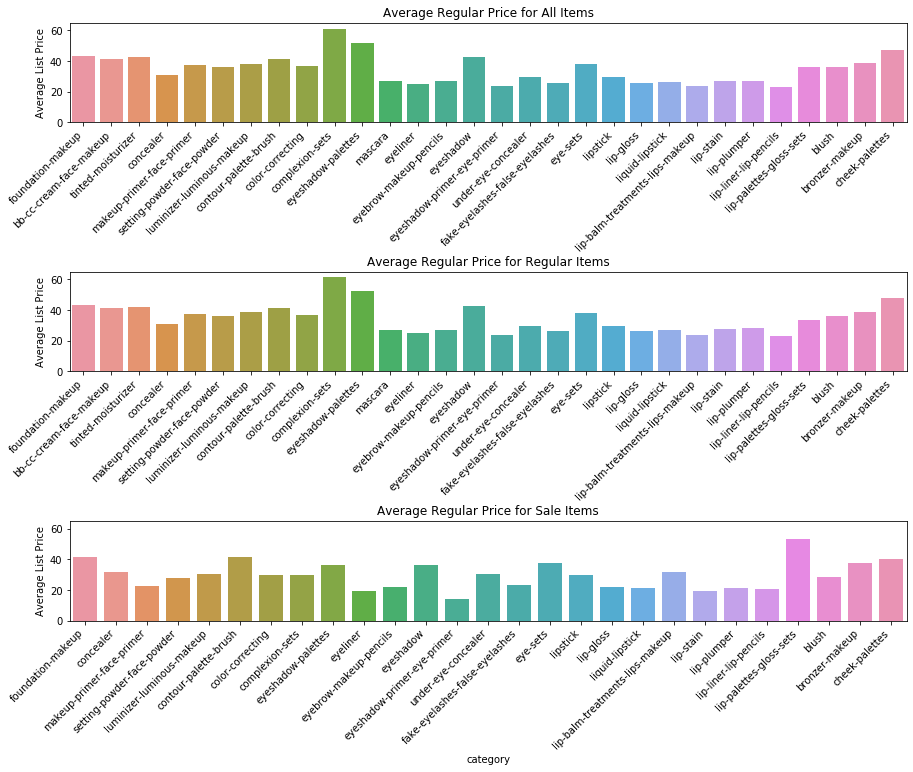

<Figure size 576x1080 with 0 Axes>

In [118]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 11), sharey = True)
plt.subplots_adjust(hspace = 1.5)
plt.figure(figsize = (8, 15))

sns.barplot(data = products, y = 'listPrice', x = 'category', ci = None, ax = ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 45)
ax[0].set_xlabel('')
ax[0].set_ylabel('Average List Price')
ax[0].set_title('Average Regular Price for All Items')

sns.barplot(data = reg_prod, y = 'listPrice', x = 'category', ci = None, ax = ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 45)
ax[1].set_xlabel('')
ax[1].set_ylabel('Average List Price')
ax[1].set_title('Average Regular Price for Regular Items')

sns.barplot(data = sale_prod, y = 'listPrice', x = 'category', ci = None, ax = ax[2])
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation = 45)
ax[2].set_ylabel('Average List Price')
ax[2].set_title('Average Regular Price for Sale Items')


for label in ax[0].get_xticklabels():
    label.set_horizontalalignment('right')
    
for label in ax[1].get_xticklabels():
    label.set_horizontalalignment('right')
    
for label in ax[2].get_xticklabels():
    label.set_horizontalalignment('right')
# fig.xticks(rotation = 45)

Text(0.5, 1.0, 'Average Regular Price for Sale Items')

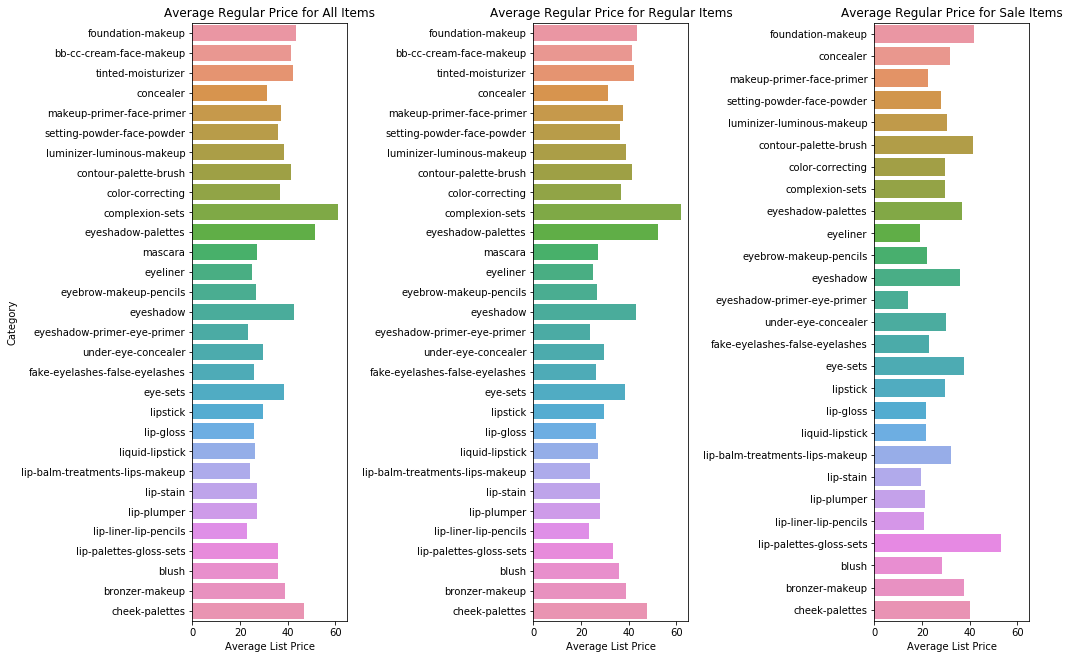

<Figure size 1080x720 with 0 Axes>

In [88]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 11), sharex = True)
plt.subplots_adjust(wspace = 1.2)
plt.figure(figsize = (15, 10))
sns.barplot(data = products, x = 'listPrice', y = 'category', ci = None, ax = ax[0])
ax[0].set_ylabel('Category')
ax[0].set_xlabel('Average List Price')
ax[0].set_title('Average Regular Price for All Items')

sns.barplot(data = reg_prod, x = 'listPrice', y = 'category', ci = None, ax = ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('Average List Price')
ax[1].set_title('Average Regular Price for Regular Items')

sns.barplot(data = sale_prod, x = 'listPrice', y = 'category', ci = None, ax = ax[2])
ax[2].set_ylabel('')
ax[2].set_xlabel('Average List Price')
ax[2].set_title('Average Regular Price for Sale Items')



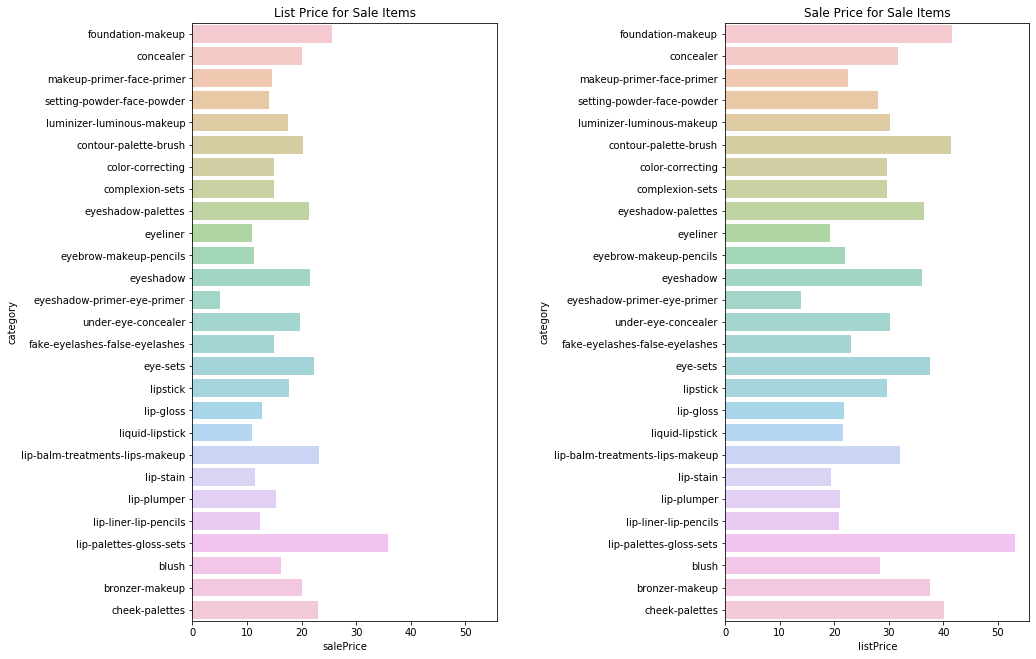

<Figure size 468x468 with 0 Axes>

In [67]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 11), sharex = True)
plt.subplots_adjust(wspace = .75)
plt.figure(figsize = (6.5,6.5))
sns.barplot(data = sale_prod, x = 'listPrice', y = 'category', alpha = .5, ci = None, ax = axes[1])
axes[0].set_title('List Price for Sale Items')
sns.barplot(data = sale_prod, x = 'salePrice', y = 'category', alpha = .5, ci = None, ax = axes[0])
axes[1].set_title('Sale Price for Sale Items');

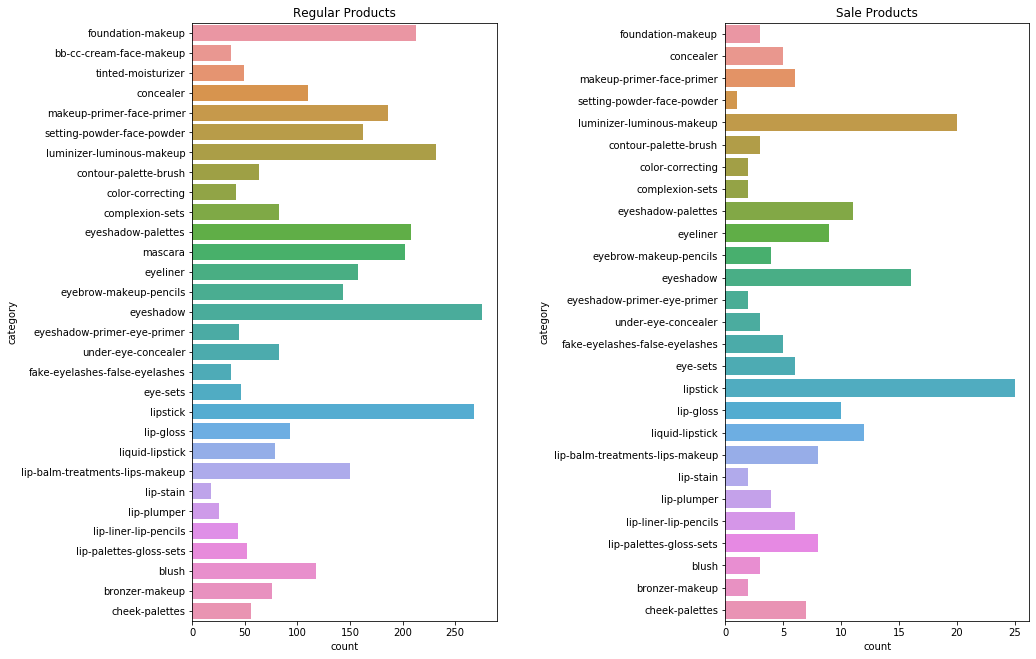

<Figure size 468x468 with 0 Axes>

In [70]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 11))
plt.subplots_adjust(wspace = .75)
plt.figure(figsize = (6.5,6.5))
sns.countplot(data = reg_prod, y = 'category', ax = axes[0])
axes[0].set_title('Regular Products')
sns.countplot(data = sale_prod, y = 'category', ax = axes[1])
axes[1].set_title('Sale Products');

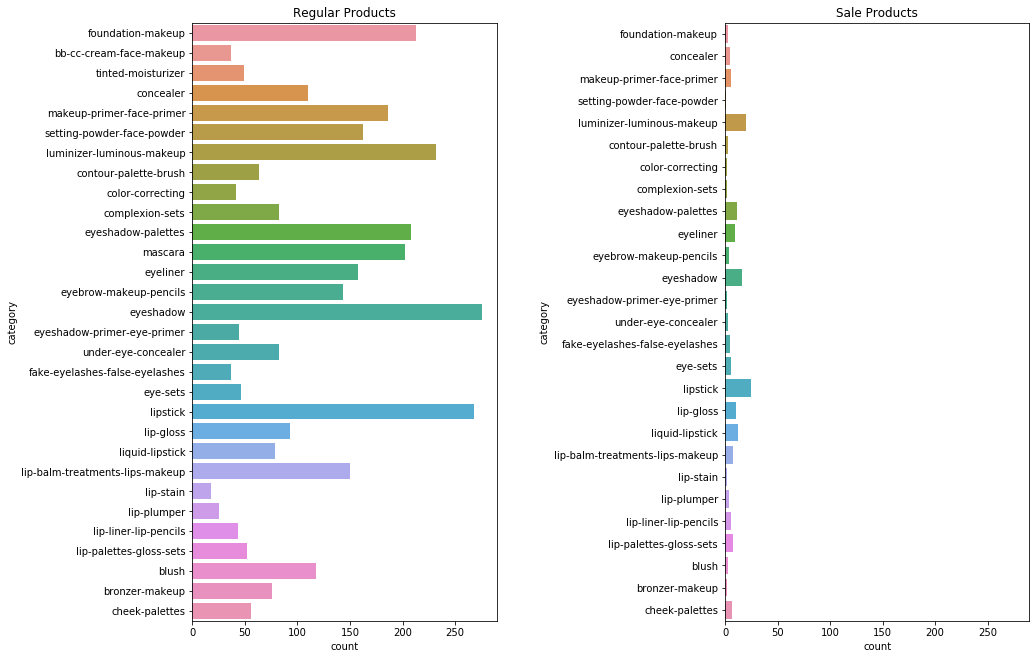

<Figure size 468x468 with 0 Axes>

In [71]:
# X-axis on the same scale
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 11), sharex = True)
plt.subplots_adjust(wspace = .75)
plt.figure(figsize = (6.5,6.5))
sns.countplot(data = reg_prod, y = 'category', ax = axes[0])
axes[0].set_title('Regular Products')
sns.countplot(data = sale_prod, y = 'category', ax = axes[1])
axes[1].set_title('Sale Products');

##### More EDA on Sale items..

In [148]:
sale_prod['isNew'].value_counts()

False    185
Name: isNew, dtype: int64

In [161]:
sale_prod['brand_name'].value_counts()[0:5]/len(sale_prod['brand_name'])

SEPHORA COLLECTION         0.281081
Black Up                   0.081081
FENTY BEAUTY by Rihanna    0.081081
Kat Von D                  0.075676
MAKE UP FOR EVER           0.059459
Name: brand_name, dtype: float64

In [159]:
sale_prod['listPrice'].value_counts(bins = 5).sort_values(ascending = False)/len(sale_prod['listPrice'])

(5.856, 34.6]     0.708108
(34.6, 63.2]      0.264865
(91.8, 120.4]     0.016216
(120.4, 149.0]    0.010811
(63.2, 91.8]      0.000000
Name: listPrice, dtype: float64

In [163]:
reg_prod['listPrice'].value_counts(bins = 8).sort_values(ascending = False)/len(reg_prod['listPrice'])

(1.731, 35.5]     0.617498
(35.5, 69.0]      0.338609
(69.0, 102.5]     0.025082
(102.5, 136.0]    0.009555
(136.0, 169.5]    0.003882
(203.0, 236.5]    0.003285
(236.5, 270.0]    0.001493
(169.5, 203.0]    0.000597
Name: listPrice, dtype: float64

In [160]:
sale_prod['salePrice'].value_counts(bins = 5).sort_values(ascending = False)/len(sale_prod['salePrice'])

(2.8970000000000002, 23.4]    0.794595
(23.4, 43.8]                  0.178378
(64.2, 84.6]                  0.016216
(84.6, 105.0]                 0.010811
(43.8, 64.2]                  0.000000
Name: salePrice, dtype: float64

- There were no new products that were put on sale. This makes sense.   
- The brand name that went on sale the most was Sephora's in house brand, the Sephora Collection. It would be the easiest to put their in house items on sale most frequently as they are not bound by any contracts. Also, there might be lots of inventory for their in house products.   
- Surprisingly, it looks as though price did not contribute much to whether an item goes on sale. The regular prices for sale items mostly fell under 63 dollars. Most non-sale items' regular prices also fell under 69 dollars.   
- Almost all items that went on sale had a sale price under 44 dollars.

In [187]:
sale_prod.corr()

,isLimitedEdition,isNew,isOnlineOnly,isSephoraExclusive,listPrice,salePrice,skuId,review_count,target,sale_pct
isLimitedEdition,1.000000,NaN,-0.174229,0.369534,0.202474,0.141921,0.295724,-0.142754,NaN,0.106143
isNew,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isOnlineOnly,-0.174229,NaN,1.000000,-0.356647,0.421093,0.499424,0.093008,-0.086338,NaN,-0.369844
isSephoraExclusive,0.369534,NaN,-0.356647,1.000000,-0.084859,-0.150774,-0.057331,-0.131464,NaN,0.299309
listPrice,0.202474,NaN,0.421093,-0.084859,1.000000,0.964979,0.196668,-0.094166,NaN,-0.272542
salePrice,0.141921,NaN,0.499424,-0.150774,0.964979,1.000000,0.228984,-0.061326,NaN,-0.474110
skuId,0.295724,NaN,0.093008,-0.057331,0.196668,0.228984,1.000000,0.050459,NaN,-0.250064
review_count,-0.142754,NaN,-0.086338,-0.131464,-0.094166,-0.061326,0.050459,1.000000,NaN,-0.058459
target,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sale_pct,0.106143,NaN,-0.369844,0.299309,-0.272542,-0.474110,-0.250064,-0.058459,NaN,1.000000


In [188]:
products.corr()

,isLimitedEdition,isNew,isOnlineOnly,isSephoraExclusive,listPrice,salePrice,skuId,review_count,target
isLimitedEdition,1.000000,0.063146,0.073460,0.222116,0.065770,0.150150,0.231287,-0.116574,0.157341
isNew,0.063146,1.000000,0.026921,0.045198,-0.030868,-0.046464,0.243254,-0.053864,-0.059671
isOnlineOnly,0.073460,0.026921,1.000000,-0.080629,0.196263,0.058771,0.119721,-0.104448,-0.011292
isSephoraExclusive,0.222116,0.045198,-0.080629,1.000000,-0.126613,0.138670,0.146101,-0.023651,0.203698
listPrice,0.065770,-0.030868,0.196263,-0.126613,1.000000,0.071287,0.087754,-0.091901,-0.052593
salePrice,0.150150,-0.046464,0.058771,0.138670,0.071287,1.000000,0.023725,-0.043220,0.778663
skuId,0.231287,0.243254,0.119721,0.146101,0.087754,0.023725,1.000000,-0.238459,0.010608
review_count,-0.116574,-0.053864,-0.104448,-0.023651,-0.091901,-0.043220,-0.238459,1.000000,-0.050780
target,0.157341,-0.059671,-0.011292,0.203698,-0.052593,0.778663,0.010608,-0.050780,1.000000


## Ratings

In [135]:
ratings.head()

,1 star,2 stars,3 stars,4 stars,5 stars,avg_rating,product_id,review_count,total_ratings,target
0,0,0,0,5,11,4.7,2268274,16,16,0
1,28,35,57,212,548,4.4,2257111,880,880,0
2,1139,1279,1324,2149,8379,4.1,2164671,14270,14270,0
3,1,10,23,115,214,4.5,2242105,363,363,0
4,213,258,299,837,3758,4.4,2112167,5365,5365,0


In [136]:
sale_ratings = ratings[ratings['target'] == 1]
reg_ratings = ratings[ratings['target'] == 0]

In [137]:
sale_ratings.describe()

,1 star,2 stars,3 stars,4 stars,5 stars,avg_rating,product_id,review_count,total_ratings,target
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,1.090000e+02,109.000000,109.000000,109.0
mean,23.440367,20.862385,28.889908,70.752294,167.761468,3.855963,1.928570e+06,311.706422,311.706422,1.0
std,48.848108,46.593289,70.305595,186.650404,414.029743,0.534968,1.577955e+05,750.763085,750.763085,0.0
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.700000,1.501428e+06,5.000000,5.000000,1.0
25%,3.000000,3.000000,4.000000,6.000000,14.000000,3.600000,1.813930e+06,33.000000,33.000000,1.0
50%,9.000000,8.000000,8.000000,15.000000,41.000000,3.900000,1.911171e+06,85.000000,85.000000,1.0
75%,25.000000,16.000000,18.000000,31.000000,100.000000,4.300000,2.060762e+06,180.000000,180.000000,1.0
max,304.000000,313.000000,481.000000,1175.000000,2646.000000,4.700000,2.226785e+06,4919.000000,4919.000000,1.0


In [138]:
reg_ratings.describe()

,1 star,2 stars,3 stars,4 stars,5 stars,avg_rating,product_id,review_count,total_ratings,target
count,2174.000000,2174.000000,2174.000000,2174.000000,2174.000000,2174.000000,2.174000e+03,2174.000000,2174.000000,2174.0
mean,44.471941,45.971021,62.406164,152.092456,477.283809,4.149770,1.875873e+06,782.225391,782.225391,0.0
std,112.386933,106.706644,132.995034,321.259547,1141.141360,0.418649,3.690001e+05,1740.717521,1740.717521,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.800000,5.153200e+04,1.000000,1.000000,0.0
25%,2.000000,3.000000,4.000000,6.000000,23.000000,3.900000,1.727408e+06,40.000000,40.000000,0.0
50%,10.000000,11.000000,15.000000,30.000000,98.500000,4.200000,1.968981e+06,174.500000,174.500000,0.0
75%,38.000000,42.750000,63.000000,149.000000,412.750000,4.400000,2.137183e+06,708.250000,708.250000,0.0
max,1766.000000,1742.000000,1772.000000,2989.000000,15008.000000,5.000000,2.274298e+06,19413.000000,19413.000000,0.0


From a first glance, the average rating for sale products was not much lower than the average rating from regular priced items. There were much fewer ratings for sale products however. At the 75th percentile, 75% of sale items' review count fell under 180. While for regular priced products at the 50th percentile, the review count was up to 175 reviews. 

In [164]:
pd.DataFrame(sale_ratings.sum()[0:5]/sum(sale_ratings.sum()[0:5]))

,0
1 star,0.075200
2 stars,0.066930
3 stars,0.092683
4 stars,0.226984
5 stars,0.538203


In [165]:
pd.DataFrame(reg_ratings.sum()[0:5]/sum(reg_ratings.sum()[0:5]))

,0
1 star,0.056853
2 stars,0.058770
3 stars,0.079780
4 stars,0.194436
5 stars,0.610161


On average, sale products had more products given 1 stars or 2 stars ratings. The regular ratings also had a higher average rate of 5 star ratings

In [219]:
ratings.corr()

,1 star,2 stars,3 stars,4 stars,5 stars,avg_rating,product_id,review_count,total_ratings,target
1 star,1.000000,0.968431,0.899483,0.769757,0.677213,-0.120928,-0.175704,0.778647,0.778647,-0.040675
2 stars,0.968431,1.000000,0.962499,0.848022,0.756964,-0.065142,-0.187375,0.850077,0.850077,-0.051118
3 stars,0.899483,0.962499,1.000000,0.946173,0.862125,0.013932,-0.206773,0.933228,0.933228,-0.054618
4 stars,0.769757,0.848022,0.946173,1.000000,0.943861,0.103591,-0.236716,0.977204,0.977204,-0.054795
5 stars,0.677213,0.756964,0.862125,0.943861,1.000000,0.151391,-0.234709,0.985575,0.985575,-0.058985
avg_rating,-0.120928,-0.065142,0.013932,0.103591,0.151391,1.000000,-0.032204,0.107573,0.107573,-0.145933
product_id,-0.175704,-0.187375,-0.206773,-0.236716,-0.234709,-0.032204,1.000000,-0.236150,-0.236150,0.031056
review_count,0.778647,0.850077,0.933228,0.977204,0.985575,0.107573,-0.236150,1.000000,1.000000,-0.058703
total_ratings,0.778647,0.850077,0.933228,0.977204,0.985575,0.107573,-0.236150,1.000000,1.000000,-0.058703
target,-0.040675,-0.051118,-0.054618,-0.054795,-0.058985,-0.145933,0.031056,-0.058703,-0.058703,1.000000


## Summaries

In [179]:
summaries.head()

,product_id,a little go a long way,absorbs quickly,affordable,amazing,awesome,awful,beautiful,beautiful color,blend easily,...,very black,very pigmented,vibrant,volumizing,water resistant,waterproof,watery,weightless,wonderful,target
0,51532,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,51573,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,51904,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,52852,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,54312,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [263]:
# Create positive and negative weights for the key words in the summaries dataset 
key_word_weights = {}
for words in summaries.columns:
    key_word_weights[words] = {}
    ss = sid.polarity_scores(words)
    for k in sorted(ss):
        key_word_weights[words][k] = ss[k]

In [265]:
key_word_sentiment = pd.DataFrame.from_dict(key_word_weights, orient = 'index')

In [312]:
summaries['compound_score'] = None
for i_1 in range(len(summaries)):
    compound = 0
    for i_2 in range(len(key_word_sentiment)):
        if key_word_sentiment.index[i_2] in summaries.iloc[i_1][1:]:
            compound += key_word_sentiment.iloc[i_2]['compound'] * summaries.iloc[i_1][key_word_sentiment.index[i_2]]
    summaries.at[i_1, 'compound_score'] = compound

In [322]:
from sklearn.preprocessing import StandardScaler

Scale our compound scores so we can compare the two

In [324]:
ss = StandardScaler()
compound_sc = ss.fit_transform(summaries[['compound_score']])

In [326]:
summaries['compound_sc'] = compound_sc

In [327]:
sale_summaries = summaries[summaries['target'] == 1]
reg_summaries = summaries[summaries['target'] == 0]

In [328]:
sale_summaries.drop(columns = ['product_id', 'target', 'compound_score', 'compound_sc']).sum().sort_values(ascending = False)[0:10]/sum(sale_summaries.drop(columns = ['product_id', 'target', 'compound_score', 'compound_sc']).sum())
                                                                                      

full coverage       0.166280
lightweight         0.118590
nondrying           0.104312
creamy              0.089119
long wearing        0.082718
glide on easily     0.068158
soft                0.058592
natural looking     0.046775
color correcting    0.036154
moisturizing        0.030668
dtype: float64

In [329]:
reg_summaries.drop(columns = ['product_id', 'target', 'compound_score', 'compound_sc']).sum().sort_values(ascending = False)[0:10]/sum(reg_summaries.drop(columns = ['product_id', 'target', 'compound_score', 'compound_sc']).sum())


long wearing          0.115468
lengthening           0.065950
volumizing            0.057891
defining              0.055737
buildable coverage    0.050088
creamy                0.046504
natural looking       0.039358
long lasting          0.035205
moisturizing          0.030400
waterproof            0.028982
dtype: float64

Interestingly, for the keywords seen in sale item reviews, the key words were mostly positive words. There were also many similarities in the top key words for the regular and sale priced items.

Looking at sentiment..

In [318]:
sale_summaries['compound_score'].mean()

19.488536363636364

In [319]:
reg_summaries['compound_score'].mean()

53.85351505813946

Based on the average sentiment, it should be noted that regularly priced items had a much more positive sentiment score. HOWEVER, because regularly priced items have much more reviews in general, it will skew the average compound score

In [330]:
sale_summaries['compound_sc'].mean()

-0.11824069103961317

In [331]:
reg_summaries['compound_sc'].mean()

0.006049523727608092

Think about the constrution of weights .. divide by the total word frequency. and DON'T NEED TO SCALE

In [320]:
sale_summaries['compound_score'].value_counts(bins = 5)

(-0.705, 68.221]      41
(273.966, 342.548]     1
(205.384, 273.966]     1
(68.221, 136.802]      1
(136.802, 205.384]     0
Name: compound_score, dtype: int64

In [321]:
reg_summaries['compound_score'].value_counts(bins = 5)

(-17.639000000000003, 1078.998]    855
(3261.358, 4352.537]                 2
(1078.998, 2170.178]                 2
(4352.537, 5443.717]                 1
(2170.178, 3261.358]                 0
Name: compound_score, dtype: int64

In [333]:
sale_summaries['compound_sc'].value_counts(bins = 5)

(-0.192, 0.058]    41
(0.802, 1.05]       1
(0.554, 0.802]      1
(0.058, 0.306]      1
(0.306, 0.554]      0
Name: compound_sc, dtype: int64

In [332]:
reg_summaries['compound_sc'].value_counts(bins = 5)

(-0.254, 3.714]     855
(11.607, 15.553]      2
(3.714, 7.66]         2
(15.553, 19.5]        1
(7.66, 11.607]        0
Name: compound_sc, dtype: int64

In [385]:
compound_summaries = summaries[['compound_score', 'product_id']]

## Reviews

In [212]:
reviews.drop_duplicates(subset = 'review', inplace = True)

In [216]:
reviews.reset_index(drop = True, inplace = True)

In [193]:
# Stem reviews 
p_stem = PorterStemmer()
reviews['stem'] = reviews['review'].apply(lambda x: 
                               re.sub('[^a-zA-Z\s]', "", 
                                      " ".join([p_stem.stem(word) for word in str(x).split()])).strip())

In [199]:
stopwords = stopwords.words('english')

In [204]:
reviews['review_nsw'] = reviews['review'].apply(lambda x: 
                                                " ".join([word for word in str(x).split() if word not in stopwords]))

In [217]:
reviews['stem_nsw'] = reviews['review_nsw'].apply(lambda x: 
                               re.sub('[^a-zA-Z\s]', "", 
                                      " ".join([p_stem.stem(word) for word in str(x).split()])).strip())

In [221]:
sid = SentimentIntensityAnalyzer()

In [351]:
reviews['compound'] = None
reviews['pos'] = None
reviews['neg'] = None
reviews['neu'] = None
for i in range(len(reviews['review'])):
    ss = sid.polarity_scores(reviews['review'][i])
    for k in sorted(ss):
        reviews.at[i, k] = float(ss[k])

In [352]:
reviews.head()

,age_range,eye_color,product_id,rating,review,skin_tone,skin_type,title,user,target,stem,review_nsw,stem_nsw,length,compound,pos,neg,neu
0,NaN,Brown,2268274,5,"WOW! I love this foundation, and the packaging...",Olive,Combination,Love this foundation in addition to the soft m...,TyraFox,0,wow I love thi foundation and the packag is ev...,"WOW! I love foundation, packaging even better!...",wow I love foundation packag even better iv us...,241,0.9566,0.295,0,0.705
1,NaN,Brown,2268274,5,I mean do you really have to know that she did...,Deep,Normal,And ANOTHER!,KendraAb,0,I mean do you realli have to know that she did...,I mean really know again. I actually combinati...,I mean realli know again I actual combin skin ...,427,0.9734,0.227,0,0.773
2,NaN,Brown,2268274,5,So i normally use the matte Fenty Matte Founda...,Deep,Combination,Food For Your Skin,UGBASTIAN89,0,So i normal use the matt fenti matt foundat wh...,So normally use matte Fenty Matte Foundation I...,So normal use matt fenti matt foundat I absolu...,557,0.9611,0.182,0.029,0.789
3,NaN,Brown,2268274,5,A natural finish and at the same time gives co...,NaN,Oily,Feels airy and fresh with natural coverage,veens,0,A natur finish and at the same time give cover...,A natural finish time gives coverage. It didnt...,A natur finish time give coverage It didnt fee...,288,0.8111,0.195,0.082,0.723
4,18-24,Brown,2268274,4,"Uh, at first I wanted to rate this a tad bit l...",Dark,Combination,Oh man...,KhrisGal,0,uh at first I want to rate thi a tad bit lower...,"Uh, first I wanted rate tad bit lower due comb...",uh first I want rate tad bit lower due combo l...,305,0.906,0.213,0.06,0.727


In [335]:
reviews['length'] = reviews['review'].map(lambda x: len(x))

In [353]:
reviews.dtypes

age_range     object
eye_color     object
product_id     int64
rating         int64
review        object
skin_tone     object
skin_type     object
title         object
user          object
target         int64
stem          object
review_nsw    object
stem_nsw      object
length         int64
compound      object
pos           object
neg           object
neu           object
dtype: object

In [357]:
for col in ['compound', 'pos', 'neg', 'neu']:
    reviews[col] = reviews[col].map(lambda x: float(x))

In [359]:
reviews.groupby(by = 'product_id').mean()['compound'].value_counts(bins = 5)

(0.383, 0.682]      897
(0.682, 0.982]      652
(0.0832, 0.383]     108
(-0.216, 0.0832]      6
(-0.518, -0.216]      2
Name: compound, dtype: int64

In [361]:
reviews['compound'].value_counts(bins = 5)

(0.602, 0.999]      26359
(0.206, 0.602]       4725
(-0.191, 0.206]      2614
(-0.587, -0.191]     1937
(-0.987, -0.587]     1343
Name: compound, dtype: int64

In [375]:
reviews[reviews['target'] == 1]['compound'].value_counts(bins =10)/len(reviews[reviews['target'] == 1])

(0.802, 0.997]      0.481807
(0.607, 0.802]      0.164994
(0.412, 0.607]      0.080928
(0.217, 0.412]      0.055834
(-0.173, 0.0222]    0.051443
(-0.563, -0.368]    0.041405
(-0.757, -0.563]    0.032622
(0.0222, 0.217]     0.031995
(-0.955, -0.757]    0.030740
(-0.368, -0.173]    0.028231
Name: compound, dtype: float64

In [376]:
reviews[reviews['target'] == 0]['compound'].value_counts(bins =10)/len(reviews[reviews['target'] == 0])

(0.8, 0.999]        0.534140
(0.602, 0.8]        0.181523
(0.404, 0.602]      0.079273
(0.206, 0.404]      0.048129
(-0.191, 0.0075]    0.044342
(-0.587, -0.389]    0.026142
(0.0075, 0.206]     0.025803
(-0.389, -0.191]    0.025407
(-0.785, -0.587]    0.020885
(-0.987, -0.785]    0.014357
Name: compound, dtype: float64

In [388]:
compound_ratings = pd.DataFrame(reviews.groupby(by = 'product_id').mean()['compound'])

In [414]:
reviews['user'].value_counts()[1:11]

mistyrayne        52
Mochapj           36
glowholic         32
makeupfreak12     32
TheMACIsBack      24
Ellen5            21
jonieku           21
crisymei          20
Mallerlyn         20
NOneRouge         19
Name: user, dtype: int64

Check to see the demographics of the most review writing users

# All the Pieces Together

In [392]:
w_ratings = pd.merge(products, ratings, how = 'left', left_on = 'skuId', right_on = 'product_id')

In [395]:
w_summ = pd.merge(w_ratings, compound_summaries, how = 'left', left_on = 'skuId', right_on = 'product_id')

In [396]:
w_summ.columns

Index(['brand_name', 'category', 'imageAltText', 'isLimitedEdition', 'isNew',
       'isOnlineOnly', 'isSephoraExclusive', 'listPrice', 'salePrice', 'skuId',
       'skuType', 'valuePrice', 'review_count_x', 'target_x', '1 star',
       '2 stars', '3 stars', '4 stars', '5 stars', 'avg_rating',
       'product_id_x', 'review_count_y', 'total_ratings', 'target_y',
       'compound_score', 'product_id_y'],
      dtype='object')

In [397]:
w_summ.drop(columns = ['product_id_x', 'product_id_y', 'target_y'], inplace = True)

In [399]:
final_df = pd.merge(w_summ, compound_ratings, how = 'left', left_on = 'skuId', right_on = 'product_id')

In [403]:
final_df.drop_duplicates(subset = 'skuId', inplace = True)

In [409]:
final_df.drop(columns = 'review_count_x', inplace = True)

In [410]:
final_df.to_csv('final_dataset.csv')